In [1]:
import os
import re
import PIL
import sys
import json
import time
import timm
import math
import copy
import torch
import pickle
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
from apex import amp
import seaborn as sns
import albumentations
import torch.nn as nn
from PIL import Image
from pathlib import Path
from copy import deepcopy
import scikitplot as skplt
from sklearn import metrics
import torch.optim as optim
from timm import create_model
from datetime import datetime
from timm.data.loader import *
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from cutmix.cutmix import CutMix
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
#from pytorch_metric_learning import loss
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
from timm.utils import accuracy, AverageMeter
%config InlineBackend.figure_format = 'retina'
from apex.parallel import convert_syncbn_model
from timm.utils import ApexScaler, NativeScaler
from cutmix.utils import CutMixCrossEntropyLoss
from timm.models.registry import register_model
from collections import OrderedDict, defaultdict
from torch.utils.tensorboard import SummaryWriter
from warmup_scheduler import GradualWarmupScheduler
from timm.models.resnet import resnet26d, resnet50d
from torchvision import transforms, models, datasets
from timm.models.helpers import build_model_with_cfg
from torch.utils.data.sampler import SubsetRandomSampler
from randaugment import RandAugment, ImageNetPolicy, Cutout
from apex.parallel import DistributedDataParallel as ApexDDP
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.models.efficientnet import efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, auc, roc_auc_score
#from timm.data import Dataset, DatasetTar, RealLabelsImagenet, create_loader, Mixup, FastCollateMixup, AugMixDataset

In [2]:
torch.backends.cudnn.benchmark = True
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
data_dir = '/home/linh/Downloads/TB/'
#data_dir = '/home/linh/Downloads/Covid-19_CXR'
#data_dir = '/home/linh/Downloads/TB_COVID-19/data'

device = torch.device("cuda:0")
batch_size = 80
# Batch_size (48 or 50 for EfficientNet-B0, img_size=320, cuda=0 or cuda=1) 
# Batch_size (64 or 68 for EfficientNet-B1, img_size=240, cuda=0 or cuda=1)
num_epochs = 500
lr = 0.01
beta = 1
step_size = 130
img_size = 224
test_size = int((256 / 224) * img_size)
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
num_workers = 4
# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.3, 0.3, 0.3),
        RandAugment(),
        ImageNetPolicy(),
        Cutout(size=16),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomErasing(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(test_size),
        transforms.CenterCrop(img_size),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(test_size),
        transforms.CenterCrop(img_size),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers, pin_memory = True)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

print(class_names)
print(dataset_sizes)
print(device)

### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['val'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['val']))
images.size()

['NORMAL', 'PNEUMONIA', 'TB']
{'train': 21315, 'val': 3677, 'test': 3680}
cuda:0
{0: 'NORMAL', 1: 'PNEUMONIA', 2: 'TB'}


torch.Size([80, 3, 224, 224])

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.suam(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")  
    plt.show()
    
def plt_roc(test_y, probas_y, plot_micro=False, plot_macro=False):
    assert isinstance(test_y, list) and isinstance(probas_y, list), 'the type of input must be list'
    
    skplt.metrics.plot_roc(test_y, probas_y, plot_micro=plot_micro,plot_macro=plot_macro, figsize=(10, 8))
    #plt.savefig(add_prefix(args.prefix, 'roc_auc_curve.png'))
    plt.show()
    #plt.close()

In [5]:
"""def showimage(data_loader, number_images, cat_to_name):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(number_images, 4))
    for idx in np.arange(number_images):
        ax = fig.add_subplot(4, number_images/2, idx+1, xticks=[], yticks=[])
        img = np.transpose(images[idx])
        plt.imshow(img)
        ax.set_title(cat_to_name[labels.tolist()[idx]])
        
#### to show some  images
showimage(data_loader['test'], 10, cat_to_name)"""

"def showimage(data_loader, number_images, cat_to_name):\n    dataiter = iter(data_loader)\n    images, labels = dataiter.next()\n    images = images.numpy() # convert images to numpy for display\n    # plot the images in the batch, along with the corresponding labels\n    fig = plt.figure(figsize=(number_images, 4))\n    for idx in np.arange(number_images):\n        ax = fig.add_subplot(4, number_images/2, idx+1, xticks=[], yticks=[])\n        img = np.transpose(images[idx])\n        plt.imshow(img)\n        ax.set_title(cat_to_name[labels.tolist()[idx]])\n        \n#### to show some  images\nshowimage(data_loader['test'], 10, cat_to_name)"

In [6]:
def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': 1.0, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': '', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {

    # hybrid models
    'vit_small_efficientnet_b0': _cfg(),
    'vit_small_efficientnet_b1': _cfg(),
    'vit_base_efficientnet_b2': _cfg(),
    'vit_base_efficientnet_b3': _cfg(),
}


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(drop)  # seems more common to have Transformer MLP drouput here?

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.scale = 1. / dim ** 0.5
        self.num_heads = num_heads

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, attn_mask=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv[:, :, 0].transpose(1, 2), qkv[:, :, 1].transpose(1, 2), qkv[:, :, 2].transpose(1, 2)

        # TODO benchmark vs above
        #qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        #q, k, v = qkv

        attn = (q @ k.transpose(-2, -1)) * self.scale
        # FIXME support masking
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., act_layer=nn.GELU, drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, attn_drop=drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, attn_mask=None):
        x = x + self.drop_path(self.attn(self.norm1(x), attn_mask=attn_mask))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    Unfold image into fixed size patches, flatten into seq, project to embedding dim.
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, flatten_channels_last=False):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        assert img_size[0] % patch_size[0] == 0, 'image height must be divisible by the patch height'
        assert img_size[1] % patch_size[1] == 0, 'image width must be divisible by the patch width'
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        patch_dim = in_chans * patch_size[0] * patch_size[1]
        self.img_size = img_size
        self.patch_size = patch_size
        self.flatten_channels_last = flatten_channels_last
        self.num_patches = num_patches

        self.proj = nn.Linear(patch_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        Ph, Pw = self.patch_size
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        if self.flatten_channels_last:
            # flatten patches with channels last like the paper (likely using TF)
            x = x.unfold(2, Ph, Ph).unfold(3, Pw, Pw).permute(0, 2, 3, 4, 5, 1).reshape(B, -1, Ph * Pw * C)
        else:
            x = x.permute(0, 2, 3, 1).unfold(1, Ph, Ph).unfold(2, Pw, Pw).reshape(B, -1, C * Ph * Pw)
        x = self.proj(x)
        return x


class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding
    Extract feature map from CNN, flatten, project to embedding dim.
    """
    def __init__(self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                # FIXME this is hacky, but most reliable way of determining the exact dim of the output feature
                # map for all networks, the feature metadata has reliable channel and stride info, but using
                # stride to calc feature dim requires info about padding of each stage that isn't captured.
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[-1]
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            feature_dim = self.backbone.feature_info.channels()[-1]
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Linear(feature_dim, embed_dim)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., mlp_head=False, drop_rate=0., drop_path_rate=0.,
                 flatten_channels_last=False, hybrid_backbone=None):
        super().__init__()
        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
                flatten_channels_last=flatten_channels_last)
        num_patches = self.patch_embed.num_patches

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, drop=drop_rate, drop_path=dpr[i])
            for i in range(depth)])

        self.norm = nn.LayerNorm(embed_dim)
        if mlp_head:
            # paper diagram suggests 'MLP head', but results in 4M extra parameters vs paper
            self.head = Mlp(embed_dim, int(embed_dim * mlp_ratio), num_classes)
        else:
            # with a single Linear layer as head, the param count within rounding of paper
            self.head = nn.Linear(embed_dim, num_classes)

        # FIXME not quite sure what the proper weight init is supposed to be,
        # normal / trunc normal w/ std == .02 similar to other Bert like transformers
        trunc_normal_(self.pos_embed, std=.02)  # embeddings same as weights?
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @property
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def forward(self, x, attn_mask=None):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed

        for blk in self.blocks:
            x = blk(x, attn_mask=attn_mask)

        x = self.norm(x[:, 0])
        x = self.head(x)
        return x



@register_model
def vit_small_efficientnet_b0(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = efficientnet_b0(pretrained=pretrained_backbone, features_only=True, out_indices=[4])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_small_efficientnet_b0']
    return model


@register_model
def vit_small_efficientnet_b1(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = efficientnet_b1(pretrained=pretrained_backbone, features_only=True, out_indices=[4])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_small_efficientnet_b1']
    return model


@register_model
def vit_base_efficientnet_b2(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = efficientnet_b2(pretrained=pretrained_backbone, features_only=True, out_indices=[4])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_base_efficientnet_b2']
    return model


@register_model
def vit_base_efficientnet_b3(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = efficientnet_b3(pretrained=pretrained_backbone, features_only=True, out_indices=[4])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_base_efficientnnet_b3']
    return model

In [7]:
model = create_model('vit_small_patch16_224', pretrained=True) #, num_classes=num_classes)
#model = create_model('vit_base_patch16_224', pretrained=True)
#model = create_model('vit_base_patch16_384', pretrained=True) #: _cfg(input_size=(3, 384, 384)),
#model = create_model('vit_base_patch32_384', pretrained=True) # _cfg(input_size=(3, 384, 384)),
#model = create_model('vit_large_patch16_224', pretrained=True)
#model = create_model('vit_large_patch16_384', pretrained=True) # _cfg(input_size=(3, 384, 384)),
#model = create_model('vit_large_patch32_384', pretrained=True) # _cfg(input_size=(3, 384, 384)),
#model = create_model('vit_huge_patch16_224', pretrained=True)
#model = create_model('vit_huge_patch32_384', pretrained=True) #_cfg(input_size=(3, 384, 384)),
    
# hybrid models
#model = create_model('vit_small_resnet26d_224', pretrained=True)
#model = create_model('vit_small_resnet50d_s3_224', pretrained=True)
#model = create_model('vit_base_resnet26d_224', pretrained=True)
#model = create_model('vit_base_resnet50d_224', pretrained=True)
#model = create_model('vit_small_efficientnet_b0', pretrained=True)
#model = create_model('vit_small_efficientnet_b1', pretrained=True)
#model = create_model('vit_base_efficientnet_b2', pretrained=True)
#model = create_model('vit_base_efficientnet_b3', pretrained=True)
#model

In [8]:
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, num_classes)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
model
criterion = LabelSmoothingCrossEntropy()
#criterion = CutMixCrossEntropyLoss(True)
#criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
#lr = lambda x: (((1 + math.cos(x * math.pi / num_epochs)) / 2) ** 1) * 0.9
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler)
#model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
#loss_scaler = ApexScaler()
#show our model architechture and send to GPU
model.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print("The number of parameters of the model is:", count)
#model


The number of parameters of the model is: 51385251


In [9]:
#https://github.com/clovaai/CutMix-PyTorch
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=200, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']
   
    # Tensorboard summary
    writer = SummaryWriter()
    start_time_per_epoch = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs)) #(epoch, num_epochs -1)
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                r = np.random.rand(1)
                if r < 0.5: #cutmix_prob=0.5
                # generate mixed sample
                    lam = np.random.beta(beta, beta)
                    rand_index = torch.randperm(inputs.size()[0]).to(device)
                    target_a = labels
                    target_b = labels[rand_index]
                    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
                    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
                    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
 
                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 1000 == 999:
                    print('[%d, %d] loss: %.8f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    if r < 0.5:
                        loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
                    else:
                        loss = criterion(outputs, labels)
                    
                    #loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':                
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':                
                scheduler_warmup.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.8f} Acc: {:.8f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Record training loss and accuracy for each phase
            if phase == 'train':
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
                writer.flush()
            else:
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)
                writer.flush()
            # deep copy the model
            
            if phase == 'val' and epoch_acc > best_acc:
                print(f'New best model found!')
                print(f'New record ACC: {epoch_acc}, previous record acc: {best_acc}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_loss': best_loss,
                            'best_val_accuracy': best_acc,
                            'scheduler_state_dict' : scheduler.state_dict(),
                            }, 
                            CHECK_POINT_PATH
                            )
                print(f'New record acc is SAVED: {epoch_acc}')
                
        end_time_per_epoch = (time.time() - start_time_per_epoch)
        print('Time for training the last epoch: {:.0f}m {:.0f}s'.format(
        end_time_per_epoch // 60, end_time_per_epoch % 60))
        
    time_elapsed = time.time() - since
    print('Total training time complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.8f} Best val loss: {:.8f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [11]:
%load_ext tensorboard
%tensorboard --logdir runs/

Reusing TensorBoard on port 6006 (pid 4848), started 2:04:16 ago. (Use '!kill 4848' to kill it.)

In [12]:
%time
#CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/vit_small_patch16_224.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/vit_small_patch16_224_mod.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/vit_small_efficientnet_b0.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/vit_small_efficientnet_b0_mod.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/EfficientNet_B0_320.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/EfficientNet_B0_AP_320.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/EfficientNet_B0_NS_320.pth'


#CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_small_efficientnet_b0_mod.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_small_efficientnet_b1_mod.pth'
CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_small_patch16_224.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_base_patch16_224.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_large_patch16_224.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_huge_patch16_224.pth'


#CHECK_POINT_PATH = '/home/linh/Downloads/TB_COVID-19/weights/vit_small_patch16_224.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/TB_COVID-19/weights/vit_base_patch16_224.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
if checkpoint == None:
    CHECK_POINT_PATH = CHECK_POINT_PATH
model, best_val_loss, best_val_acc = train_model(model,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs = num_epochs,
                                                 checkpoint = torch.load(CHECK_POINT_PATH)
                                                 ) 
                                                
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict': scheduler.state_dict(),
            }, CHECK_POINT_PATH)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs
checkpoint loaded
Val loss: 1.5992023434559872, Val accuracy: 0.6915964101169432
Epoch 1/300
--------------------
train Loss: 1.66584524 Acc: 0.63115177
val Loss: 1.61808515 Acc: 0.66059287
Time for training the last epoch: 3m 41s
Epoch 2/300
--------------------
train Loss: 1.65458244 Acc: 0.63847056
val Loss: 1.60554449 Acc: 0.68506935
Time for training the last epoch: 7m 18s
Epoch 3/300
--------------------
train Loss: 1.65219194 Acc: 0.64137931
val Loss: 1.60693550 Acc: 0.68234974
Time for training the last epoch: 10m 51s
Epoch 4/300
--------------------
train Loss: 1.65875905 Acc: 0.63650012
val Loss: 1.60894147 Acc: 0.68724504
Time for training the last epoch: 14m 25s
Epoch 5/300
--------------------
train Loss: 1.65981762 Acc: 0.63443584
val Loss: 1.59140168 Acc: 0.68615719
Time for training the last epoch: 17m 58s
Epoch 6/300
--------------------
train Loss: 1.65878664 Acc: 0.63603096
val Loss: 1.61204825 Acc: 0.67

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
51385251
checkpoint loaded
              precision    recall  f1-score   support

           0     0.7338    0.8719    0.7969      1780
           1     0.8494    0.7153    0.7766      1830
           2     0.9167    0.3143    0.4681        70

    accuracy                         0.7834      3680
   macro avg     0.8333    0.6338    0.6805      3680
weighted avg     0.7948    0.7834    0.7806      3680



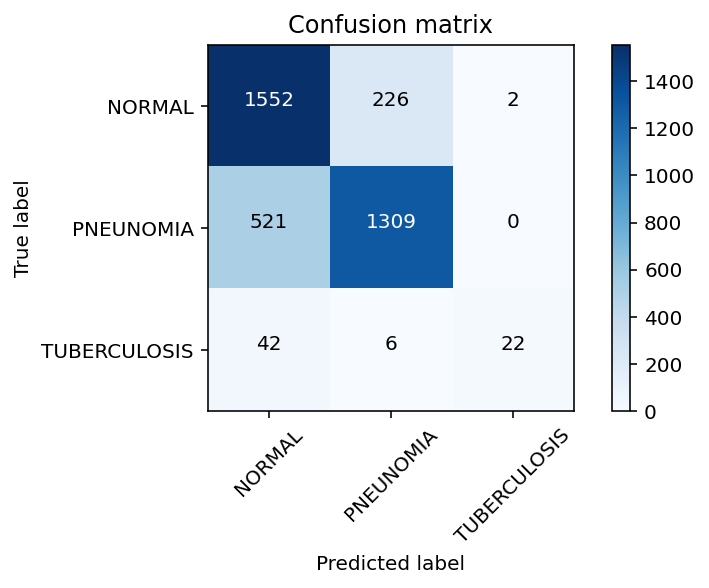

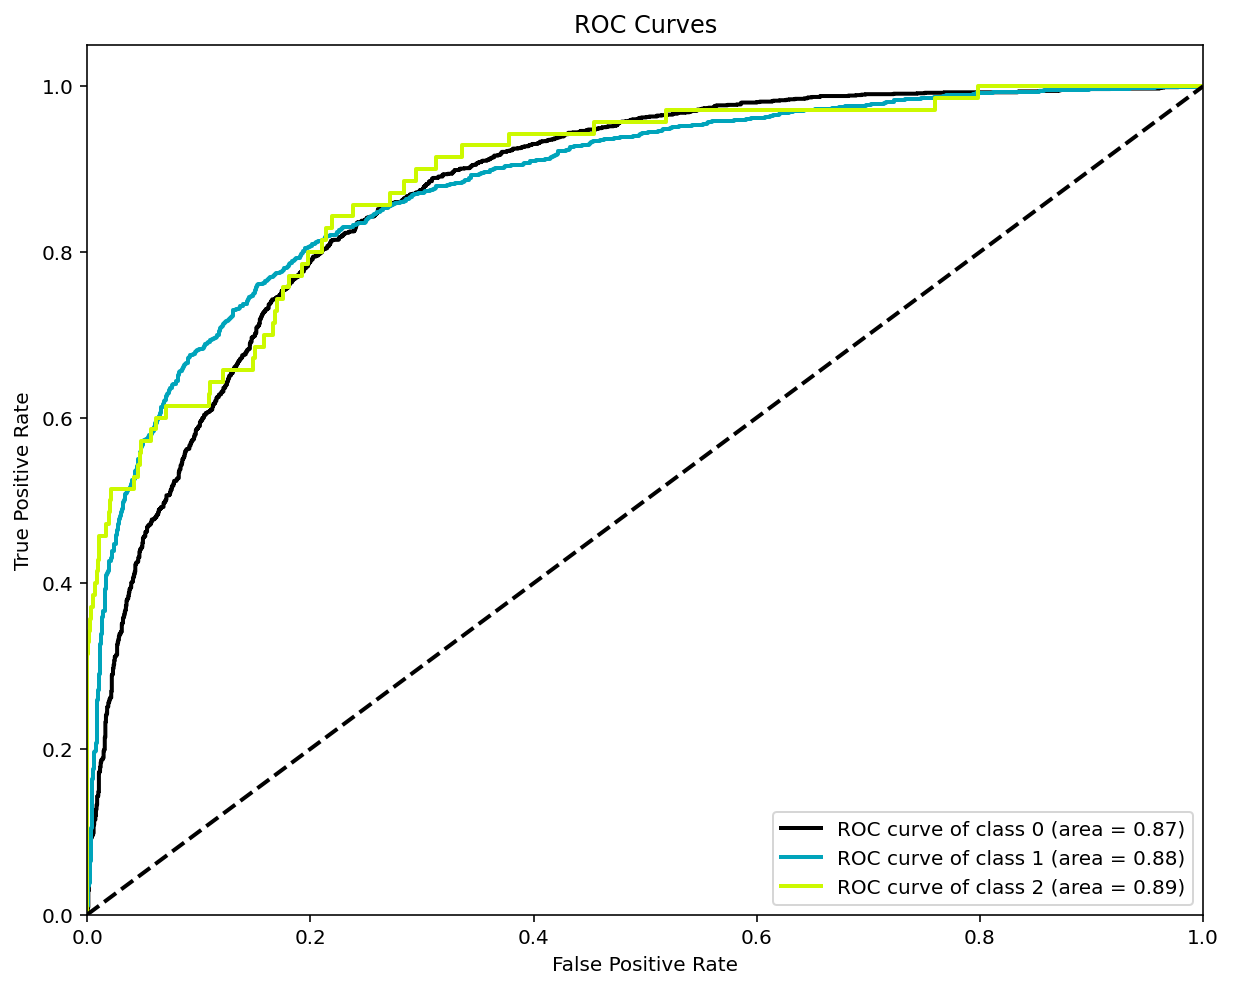

Inference completes in 0m 22s


In [13]:
%time
def compute_validate_meter(model, val_loader): # best_model_path,
    
    since = time.time()
    #CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/vit_small_patch16_224_mod.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/EfficientNet_B0_320.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/EfficientNet_B0_AP_320.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/EfficientNet_B0_NS_320.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/vit_small_patch16_224.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19_CXR/weights/vit_small_efficientnet_b0_mod.pth'
    
    #CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_small_efficientnet_b0_mod.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_small_efficientnet_b1_mod.pth'
    CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_small_patch16_224.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_base_patch16_224.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_large_patch16_224.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/vit_huge_patch16_224.pth'

    
    
    #CHECK_POINT_PATH = '/home/linh/Downloads/TB_COVID-19/weights/vit_small_patch16_224.pth'
    #CHECK_POINT_PATH = '/home/linh/Downloads/TB_COVID-19/weights/vit_base_patch16_224.pth'
    try:
        checkpoint = torch.load(CHECK_POINT_PATH)
        print("checkpoint loaded")
    except:
        checkpoint = None
        print("checkpoint not found")

    def load_model(best_model_path):                                
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']
    load_model(CHECK_POINT_PATH)
    model.to(device)
    model.eval()
    pred_y = list()
    test_y = list()
    probas_y = list()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            data, target = Variable(data), Variable(target)
            output = model(data)
            probas_y.extend(output.data.cpu().numpy().tolist())
            pred_y.extend(output.data.cpu().max(1, keepdim=True)[1].numpy().flatten().tolist())
            test_y.extend(target.data.cpu().numpy().flatten().tolist())
        # compute the confusion matrix
        confusion = confusion_matrix(test_y, pred_y)
        # plot the confusion matrix
        #plot_labels = ['NORMAL', 'PNEUNOMIA','TUBERCULOSIS']
        #plot_labels = ['COVID-19', 'NORMAL', 'PNEUNOMIA']
        plot_labels = ['COVID-19', 'NORMAL', 'NOT NORMAL & NO LUNG OPACITY'. 'PNEUMONIA', 'TUBERCULOSIS']
        plot_confusion_matrix(confusion, plot_labels)
        #plot_confusion_matrix(confusion, classes=val_loader.dataset.classes,title='Confusion matrix')
        # print Recall, Precision, F1-score, Accuracy
        report = classification_report(test_y, pred_y, digits=4)
        print(report)
        plt_roc(test_y, probas_y)
        
    time_elapsed = time.time() - since

    print('Inference completes in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)

#best_model_path = '/home/linh/Downloads/TB/weights/EfficientNet_B1_240.pth'


compute_validate_meter(model, data_loader['test']) #best_model_path,
